In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')

In [20]:
fields = ['timestamp', 'm_arch', 'm_pretrain', 'm_finetune', 'p_type', 'p_task'] \
         + [f'layer{ix}' for ix in [0, 1, 4, 5, 6, 10, 11, 12]]
df = pd.read_csv('data/probe_outputs.csv', names=fields)

In [21]:
df

,timestamp,m_arch,m_pretrain,m_finetune,p_type,p_task,layer0,layer1,layer4,layer5,layer6,layer10,layer11,layer12
0,2023_03_15-13_17,bert,mlm,none,indiv,pos,0.824708,0.903868,NaN,NaN,0.944248,0.934178,0.928009,0.922941
1,2023_03_15-13_23,bert,mlm,none,cond,pos,0.823708,0.907603,NaN,NaN,0.947649,0.946816,0.944115,0.942481
2,2023_03_15-13_27,bert,mlm,none,indiv,dep,0.600233,0.728676,NaN,NaN,0.829977,0.812738,0.798866,0.777593
3,2023_03_15-13_32,bert,mlm,none,cond,dep,0.599933,0.736579,NaN,NaN,0.833878,0.827709,0.814338,0.798133
4,2023_03_15-13_39,distilbert,mlm,none,indiv,pos,0.824475,0.916906,0.945682,0.938580,0.933845,NaN,NaN,NaN
5,2023_03_15-13_42,bert,mlm,mnli,indiv,pos,0.821774,0.895599,NaN,NaN,0.936379,0.909136,0.900800,0.896732
6,2023_03_15-13_42,distilbert,mlm,mnli,indiv,pos,0.823975,0.907336,0.925375,0.902367,0.868590,NaN,NaN,NaN
7,2023_03_15-13_43,distilbert,mlm,distmnli,indiv,pos,0.822641,0.907136,0.921841,0.890163,0.838113,NaN,NaN,NaN
8,2023_03_15-13_45,distilbert,mlm,none,cond,pos,0.823474,0.917873,0.951150,0.947316,0.943981,NaN,NaN,NaN
9,2023_03_15-13_49,distilbert,mlm,mnli,cond,pos,0.823741,0.911804,0.935412,0.928543,0.915739,NaN,NaN,NaN


In [23]:
db_layers = [0, 1, 4, 5, 6]
b_layers = [0, 1, 6, 10, 11, 12]

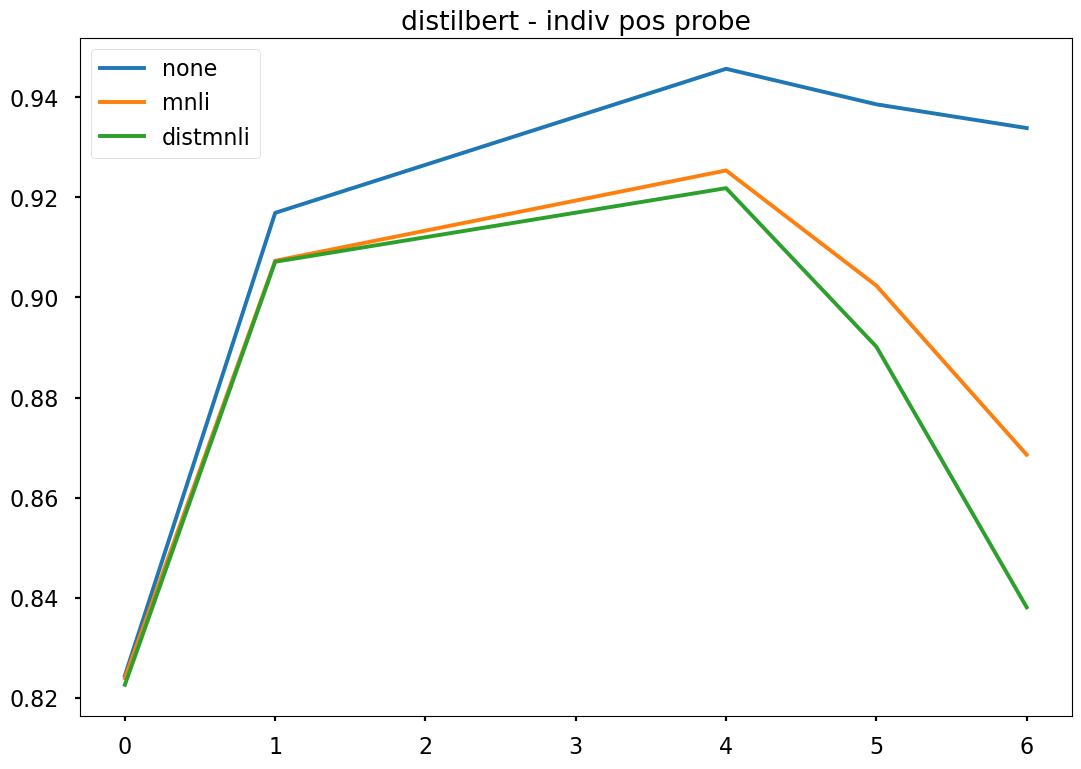

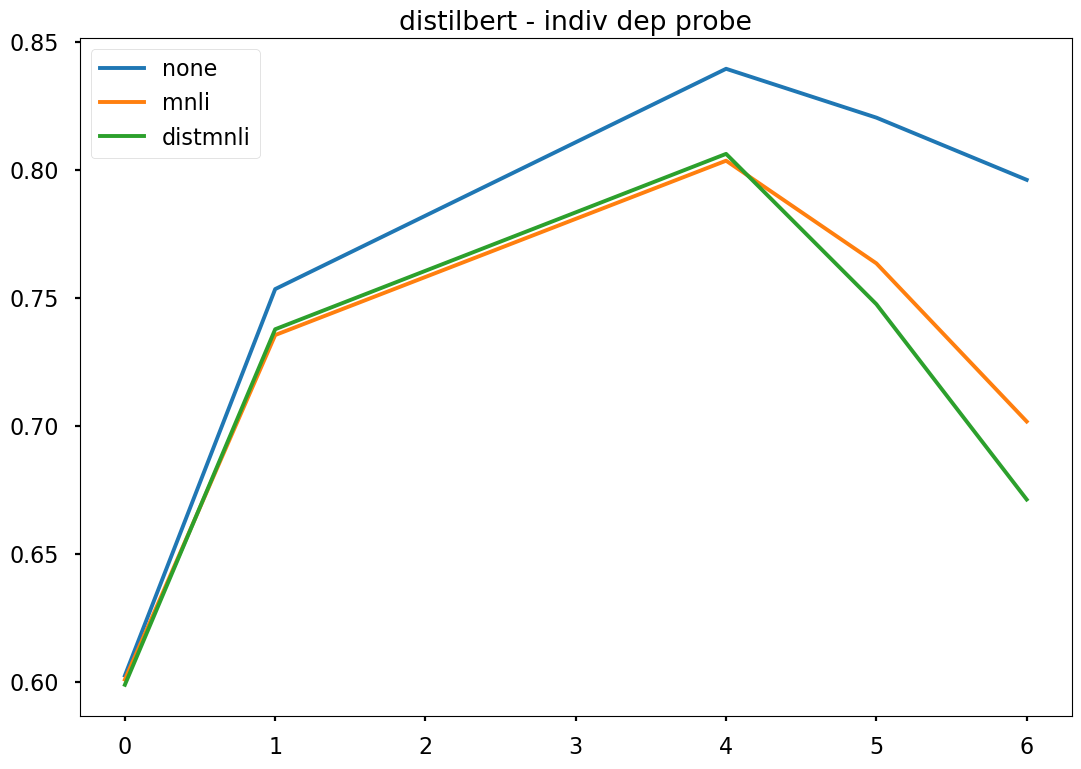

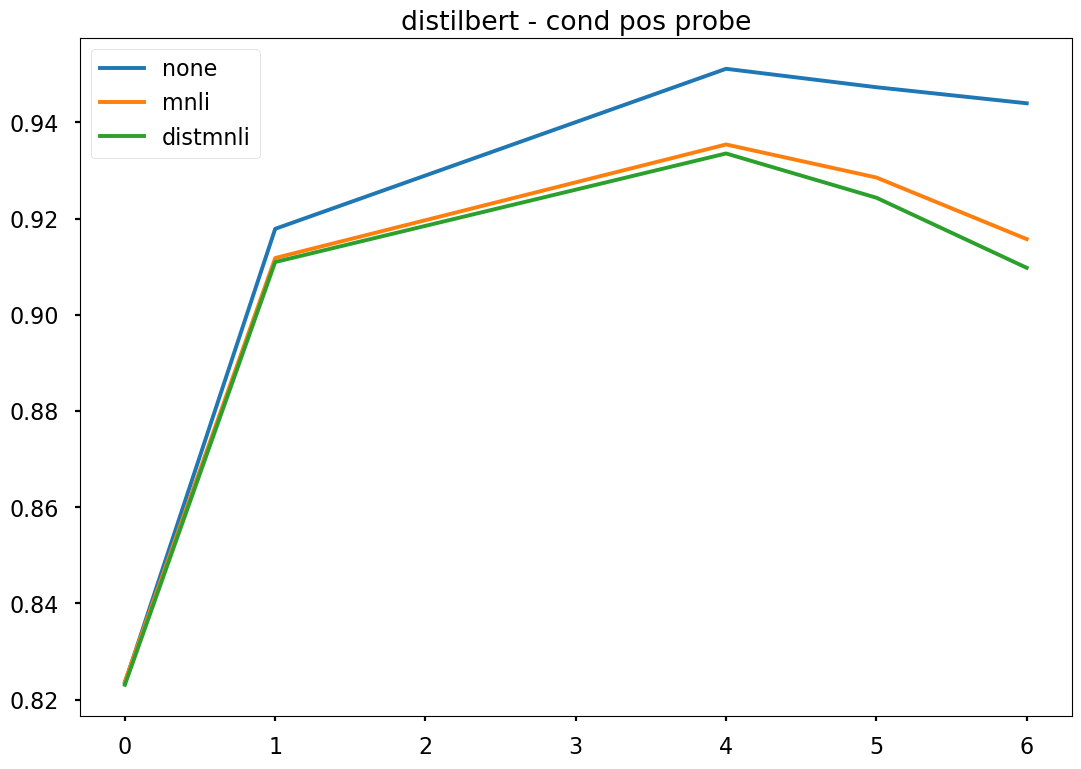

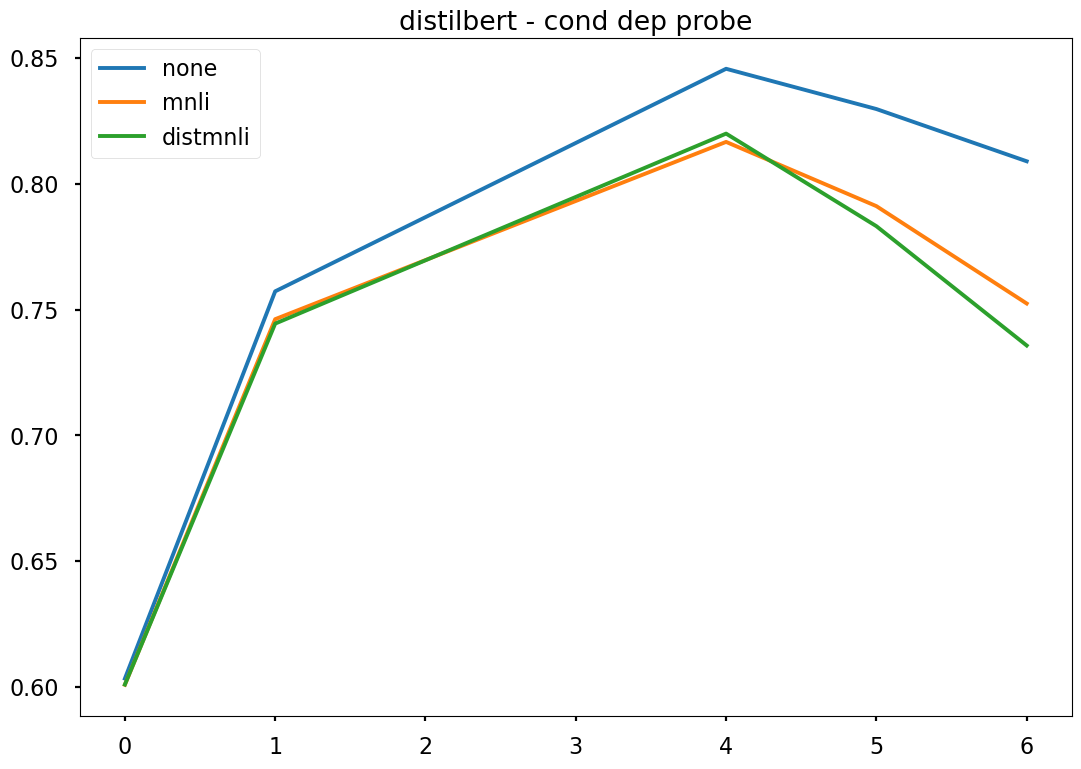

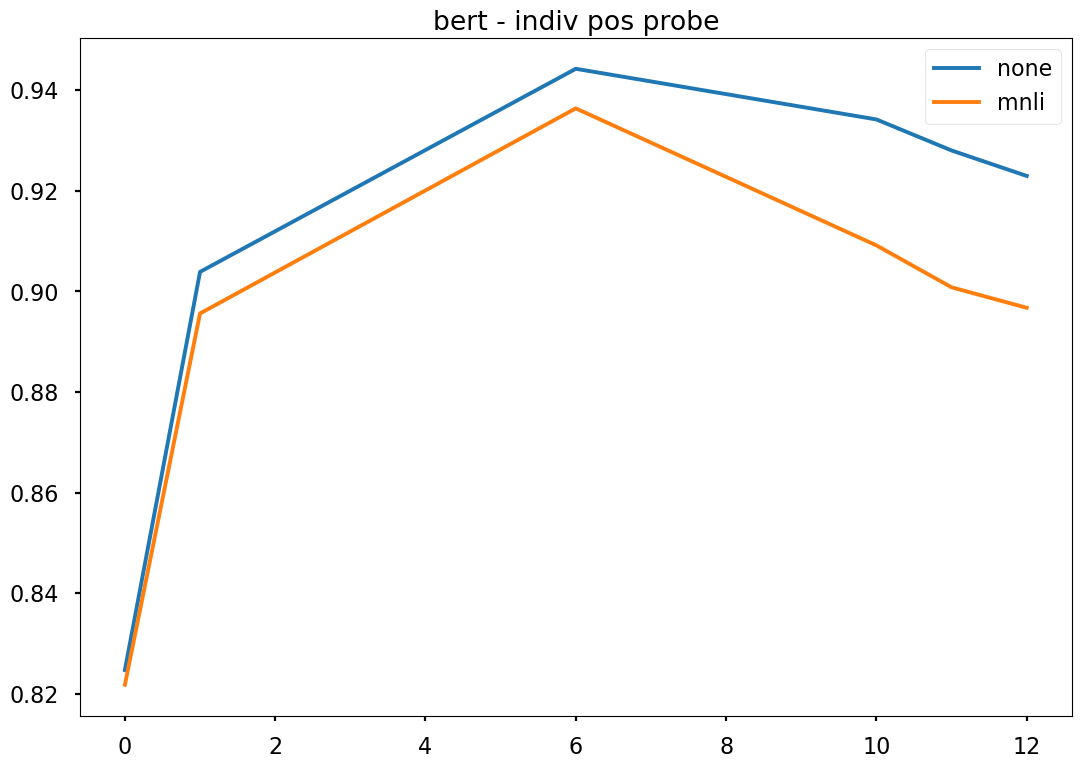

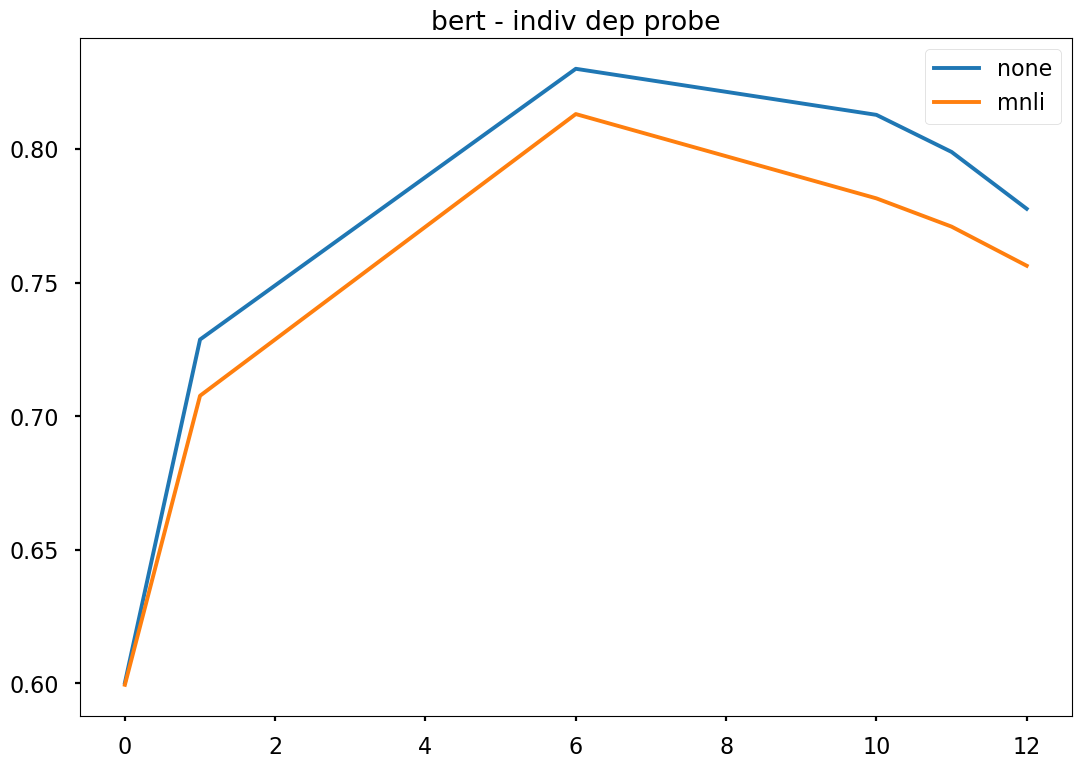

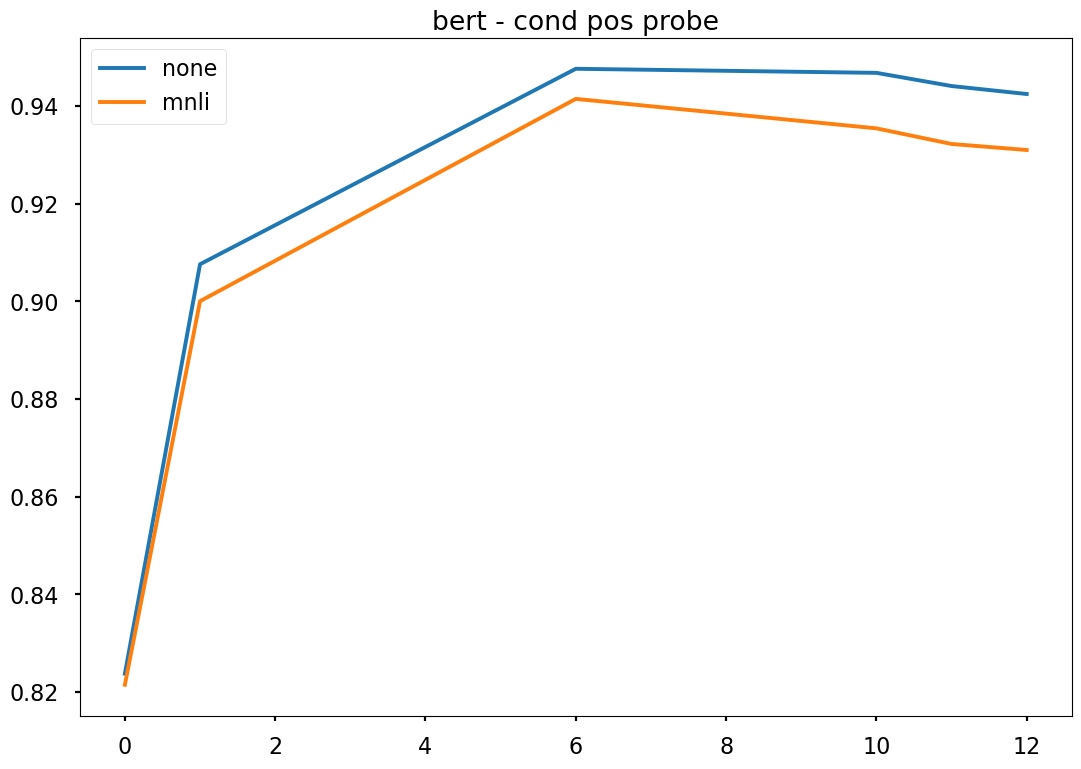

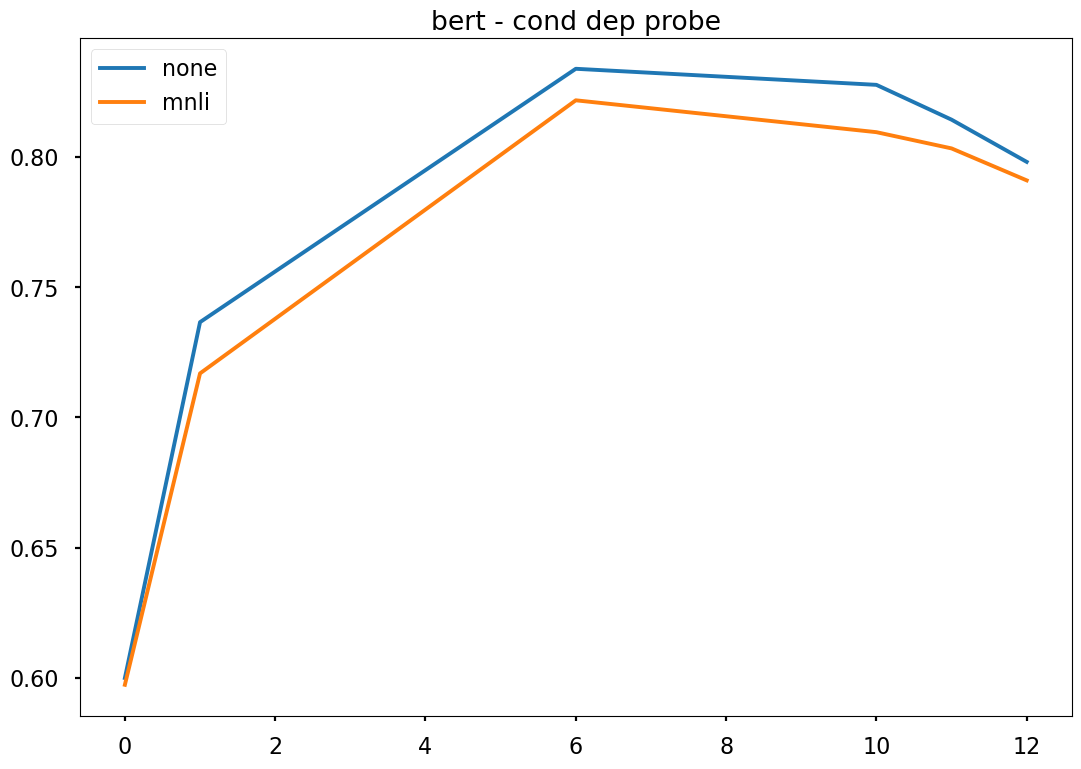

In [38]:
for model in ['distilbert', 'bert']:
    layers = b_layers if model == 'bert' else db_layers
    layer_names = [f'layer{i}' for i in layers]
    for ptype in ['indiv', 'cond']:
        tune_types = ['none', 'mnli']
        if model == 'distilbert':
            tune_types.append('distmnli')
        for t in ['pos', 'dep']:
            subdf = df[(df['m_arch'] == model) & (df['p_type'] == ptype) & (df['p_task'] == t)]
            # display(subdf)
            fig, ax = plt.subplots(1)
            ax.set_title(f"{model} - {ptype} {t} probe")
            for tt in tune_types:
                data_slice = subdf[subdf['m_finetune'] == tt][layer_names]
                ax.plot(layers, data_slice.values.flatten(), label=tt)
            ax.legend()
            fig.show()


In [24]:
dist = df[(df['model_architecture'] == 'distilbert') & \
          (df['finetuning'] == 'distmnli') & \
          (df['probe_type'] == 'individual')][layers].values.flatten()

In [26]:
pre_only = df[(df['model_architecture'] == 'distilbert') & \
              (df['finetuning'] == 'none') & \
              (df['probe_type'] == 'individual')][layers].values.flatten()

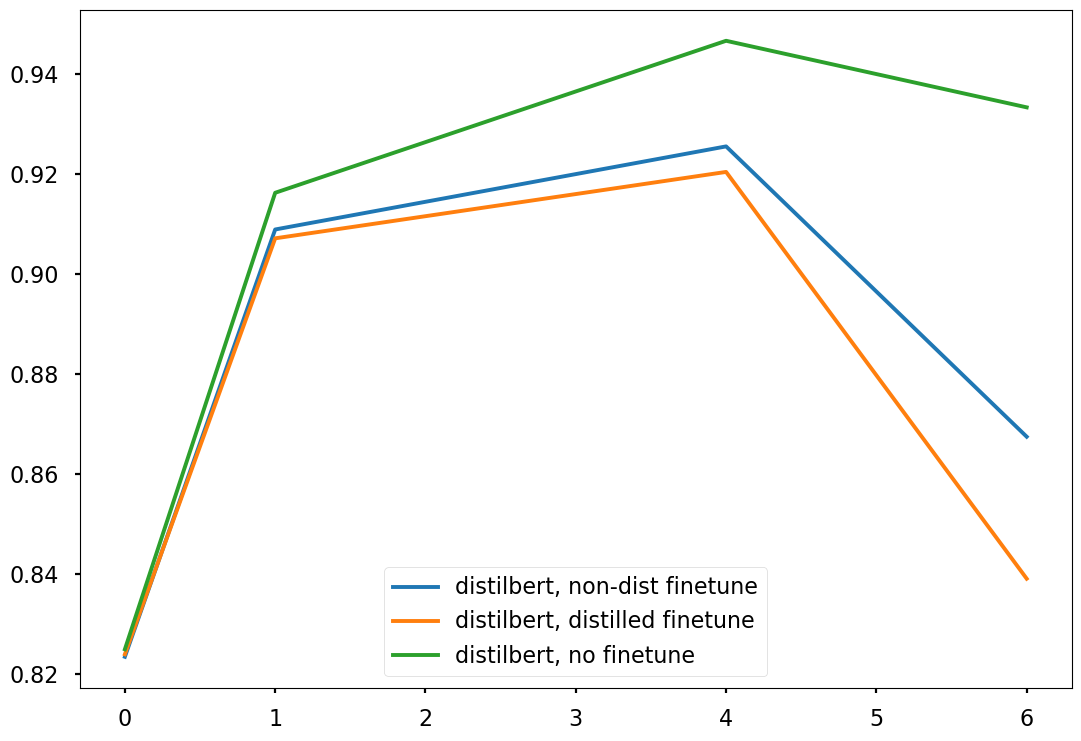

In [27]:
fig, ax = plt.subplots(1)
ax.plot(layer_nums[:-1], nondist[:-1], label='distilbert, non-dist finetune')
ax.plot(layer_nums[:-1], dist[:-1], label='distilbert, distilled finetune')
ax.plot(layer_nums[:-1], pre_only[:-1], label='distilbert, no finetune')
ax.legend()
plt.show()

In [28]:
bert_nli = df[(df['model_architecture'] == 'bert') & \
              (df['finetuning'] == 'mnli') & \
              (df['probe_type'] == 'individual')][layers].values.flatten()

In [29]:
bert_pre_only = df[(df['model_architecture'] == 'bert') & \
                   (df['finetuning'] == 'none') & \
                   (df['probe_type'] == 'individual')][layers].values.flatten()

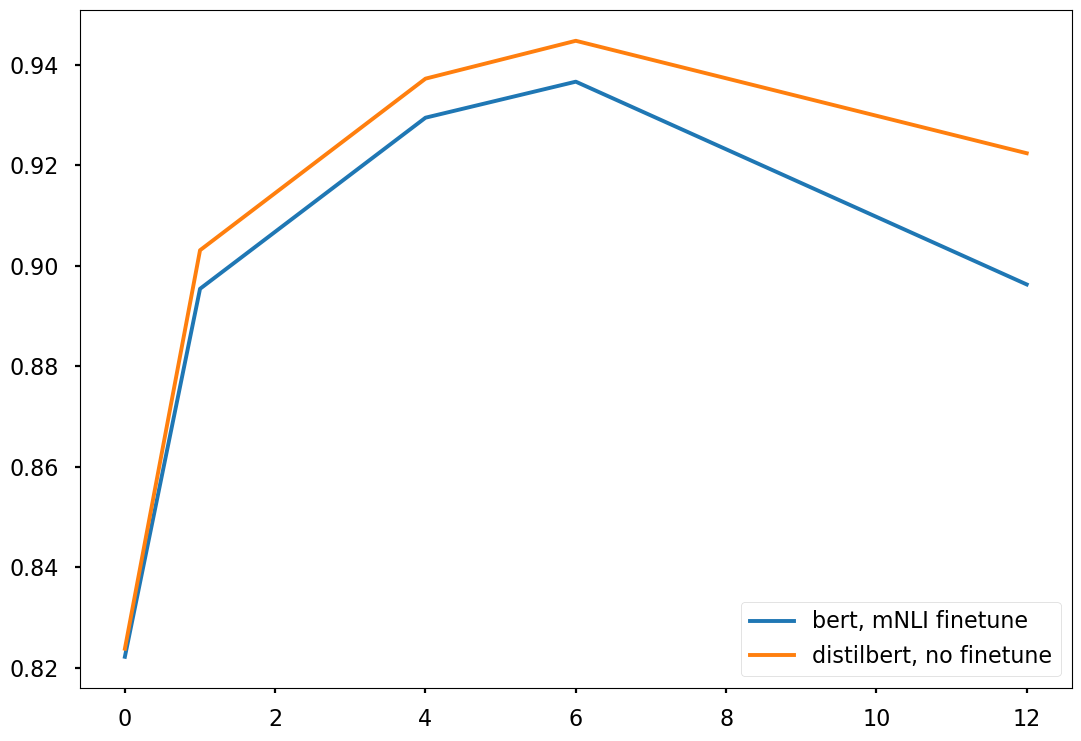

In [31]:
fig2, ax2 = plt.subplots(1)
ax2.plot(layer_nums, bert_nli, label='bert, mNLI finetune')
ax2.plot(layer_nums, bert_pre_only, label='distilbert, no finetune')
ax2.legend()
plt.show()